In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=c68ebb3667d7d82f22d18bfabc2e4c3a34a5135fbe56713a34080ec1b585ac57
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


**This script evaluates the baseline performance of pre-trained deep learning models (ResNet18, ResNet50, VGG16, DenseNet, and ViT) on the BreastMNIST dataset. It includes dataset preparation, model customization for binary classification, training and testing, and performance visualization (accuracy, loss, AUC) over epochs to identify the best-performing model**

==> Preparing data for breastmnist without augmentations..


100%|██████████| 30.9M/30.9M [00:03<00:00, 9.39MB/s]


Using downloaded and verified file: /root/.medmnist/breastmnist_224.npz
==> Initializing Models...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 170MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

==> Evaluating baseline performance...

Evaluating VGG16...
[VGG16] Epoch 1/20 | Train Acc: 61.72% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 2/20 | Train Acc: 58.79% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 3/20 | Train Acc: 62.45% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 4/20 | Train Acc: 59.71% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 5/20 | Train Acc: 59.89% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 6/20 | Train Acc: 58.97% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 7/20 | Train Acc: 63.55% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 8/20 | Train Acc: 61.17% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 9/20 | Train Acc: 61.54% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 10/20 | Train Acc: 58.42% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 11/20 | Train Acc: 60.26% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 12/20 | Train Acc: 61.90% | Test Acc: 69.23% | AUC: 0.4994
[VGG16] Epoch 13/20 | Train Acc: 58.42% | Test Acc: 69.23% | AUC: 0.4994


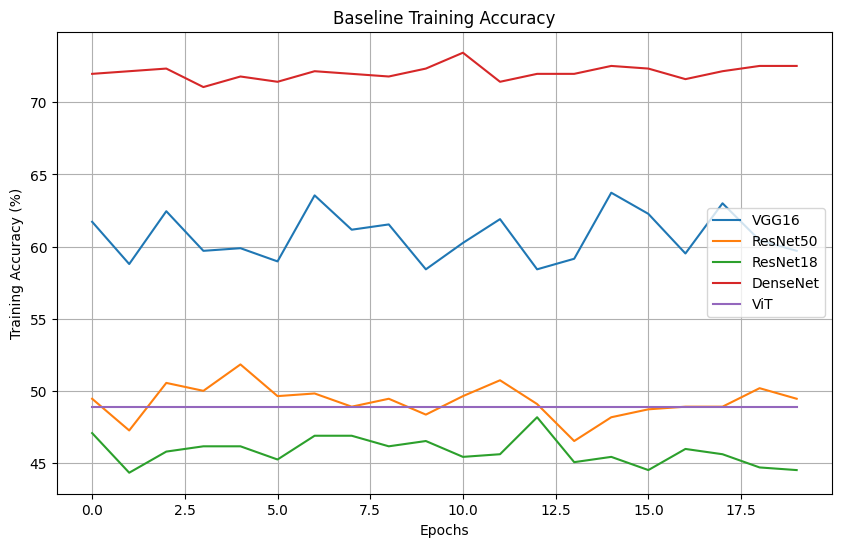

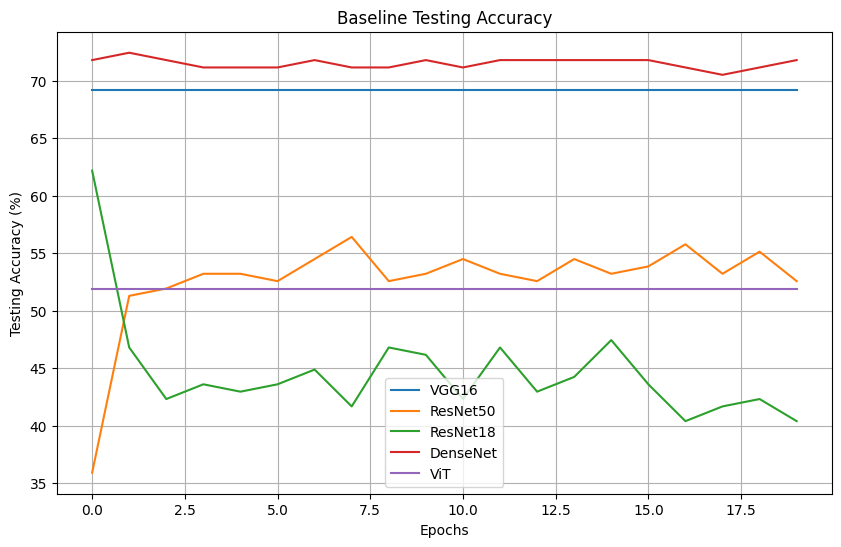

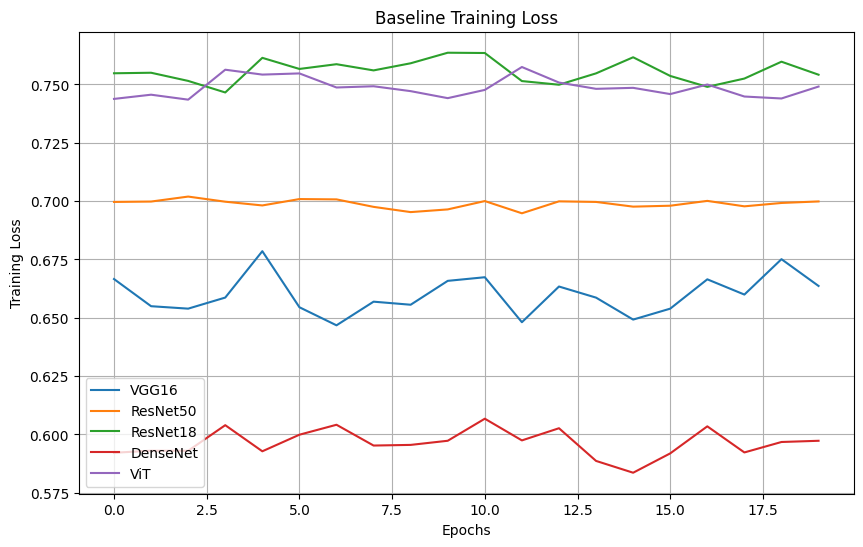

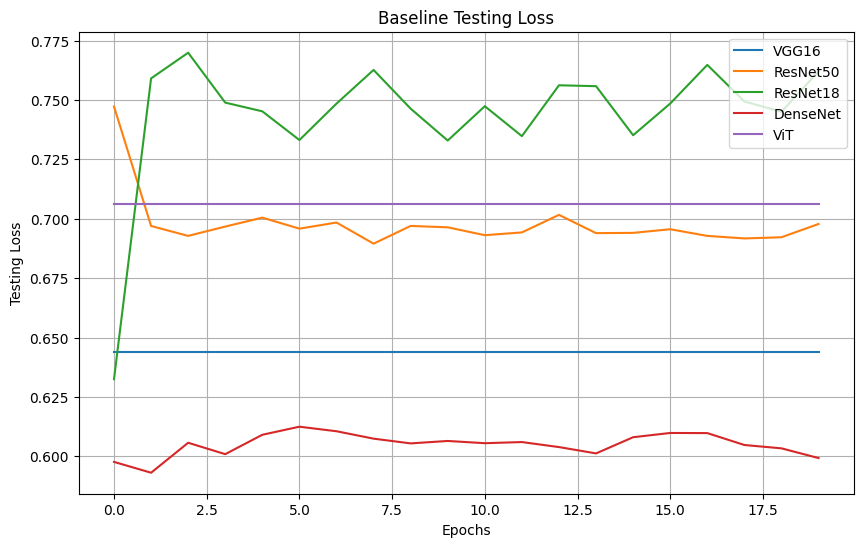

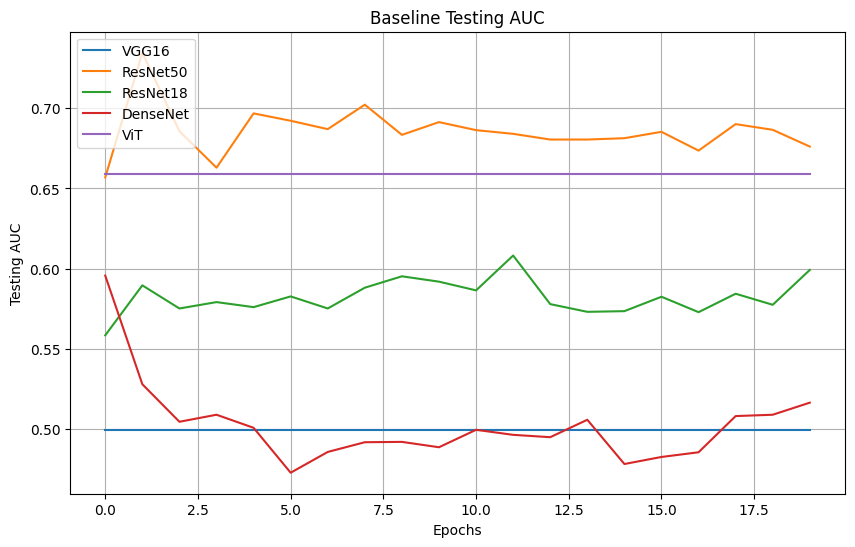

==> Baseline evaluation complete.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18, densenet121, vgg16, resnet50
from timm import create_model
from sklearn.metrics import roc_auc_score
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
import os

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset handling
dataset_name = 'breastmnist'
info = INFO[dataset_name]
DataClass = getattr(medmnist, info['python_class'])
classes = info['label']

print(f'==> Preparing data for {dataset_name} without augmentations..')

transform_baseline = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Data loaders for baseline
train_data = DataClass(split='train', transform=transform_baseline, download=True, size=224)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)

test_data = DataClass(split='test', transform=transform_baseline, download=True, size=224)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

# Directory for saving checkpoint metadata
os.makedirs("./checkpoints", exist_ok=True)  # Ensure directory exists

def save_checkpoint_metadata(model_name, epoch, train_acc, test_acc, train_loss, test_loss, test_auc):
    """Save checkpoint metadata to a text file."""
    with open("./checkpoints/checkpoints_metadata.txt", "a") as f:  # Append to metadata file
        f.write(
            f"Model: {model_name}, Epoch: {epoch}, Train Acc: {train_acc:.2f}%, "
            f"Test Acc: {test_acc:.2f}%, Train Loss: {train_loss:.4f}, "
            f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}\n"
        )

# Training and Testing Functions
def evaluate_model(model, criterion, num_epochs=1, model_name='Model'):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []
    test_auc_list = []

    for epoch in range(num_epochs):

        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() > 1:
                targets = targets.squeeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        train_loss = train_loss / len(trainloader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        model.eval()
        test_loss, correct, total = 0, 0, 0
        all_targets, all_preds = [], []

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                if targets.dim() > 1:
                    targets = targets.squeeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        test_acc = 100. * correct / total
        test_loss = test_loss / len(testloader)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        try:
            test_auc = roc_auc_score(all_targets, all_preds)
        except ValueError:
            test_auc = 0
        test_auc_list.append(test_auc)

        # Save metadata for the epoch
        save_checkpoint_metadata(model_name, epoch + 1, train_acc, test_acc, train_loss, test_loss, test_auc)

        print(
            f"[{model_name}] Epoch {epoch + 1}/{num_epochs} | "
            f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | AUC: {test_auc:.4f}"
        )

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list, test_auc_list

# Initialize Models without any modification
print('==> Initializing Models...')
models = {
    "VGG16": vgg16(pretrained=True),
    "ResNet50": resnet50(pretrained=True),
    "ResNet18": resnet18(pretrained=True),
    "DenseNet": densenet121(pretrained=True),
    "ViT": create_model('vit_base_patch16_224', pretrained=True),
}

for name, model in models.items():
    if name in ["VGG16"]:
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(classes))
    elif name in ["ResNet50", "ResNet18"]:
        model.fc = nn.Linear(model.fc.in_features, len(classes))
    elif name == "DenseNet":
        model.classifier = nn.Linear(model.classifier.in_features, len(classes))
    elif name == "ViT":
        model.head = nn.Linear(model.head.in_features, len(classes))

    models[name] = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Evaluate each model without optimizations
print('==> Evaluating baseline performance...')
baseline_results = {}

for model_name, model in models.items():
    print(f'\nEvaluating {model_name}...')
    baseline_results[model_name] = evaluate_model(
        model, criterion, num_epochs=20, model_name=model_name
    )

# Visualization
print('==> Visualizing baseline results...')

def plot_results(results, metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    for model_name, result in results.items():
        plt.plot(result[metric], label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Metrics to plot: [train_acc_list, test_acc_list, train_loss_list, test_loss_list, test_auc_list]
plot_results(baseline_results, metric=0, ylabel='Training Accuracy (%)', title='Baseline Training Accuracy')
plot_results(baseline_results, metric=1, ylabel='Testing Accuracy (%)', title='Baseline Testing Accuracy')
plot_results(baseline_results, metric=2, ylabel='Training Loss', title='Baseline Training Loss')
plot_results(baseline_results, metric=3, ylabel='Testing Loss', title='Baseline Testing Loss')
plot_results(baseline_results, metric=4, ylabel='Testing AUC', title='Baseline Testing AUC')

print('==> Baseline evaluation complete.')


**This script builds upon the baseline model evaluation by introducing data augmentation and advanced training techniques to improve performance on the BreastMNIST dataset.**

==> Preparing data for breastmnist with augmentations..
Using downloaded and verified file: /root/.medmnist/breastmnist_224.npz
Using downloaded and verified file: /root/.medmnist/breastmnist_224.npz
==> Initializing VGG16...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> Initializing ResNet50...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> Initializing ResNet18...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> Initializing DenseNet...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==> Initializing ViT...

Training VGG16...
[VGG16] Epoch 1/10 | Train Acc: 71.79% | Test Acc: 73.08% | AUC: 0.4683
[VGG16] Epoch 2/10 | Train Acc: 73.08% | Test Acc: 73.08% | AUC: 0.6815
[VGG16] Epoch 3/10 | Train Acc: 73.08% | Test Acc: 73.08% | AUC: 0.6871
[VGG16] Epoch 4/10 | Train Acc: 73.08% | Test Acc: 73.08% | AUC: 0.8028
[VGG16] Epoch 5/10 | Train Acc: 74.73% | Test Acc: 75.00% | AUC: 0.8761
[VGG16] Epoch 6/10 | Train Acc: 78.39% | Test Acc: 82.69% | AUC: 0.8732
[VGG16] Epoch 7/10 | Train Acc: 82.05% | Test Acc: 82.05% | AUC: 0.8690
[VGG16] Epoch 8/10 | Train Acc: 82.60% | Test Acc: 82.69% | AUC: 0.8885
[VGG16] Epoch 9/10 | Train Acc: 84.98% | Test Acc: 83.97% | AUC: 0.9000
[VGG16] Epoch 10/10 | Train Acc: 84.98% | Test Acc: 84.62% | AUC: 0.8906

Training ResNet50...
[ResNet50] Epoch 1/10 | Train Acc: 71.98% | Test Acc: 82.69% | AUC: 0.8557
[ResNet50] Epoch 2/10 | Train Acc: 83.52% | Test Acc: 85.26% | AUC: 0.8989
[ResNet50] Epoch 3/10 | Train Acc: 83.70% | Test Acc: 87.82% | A

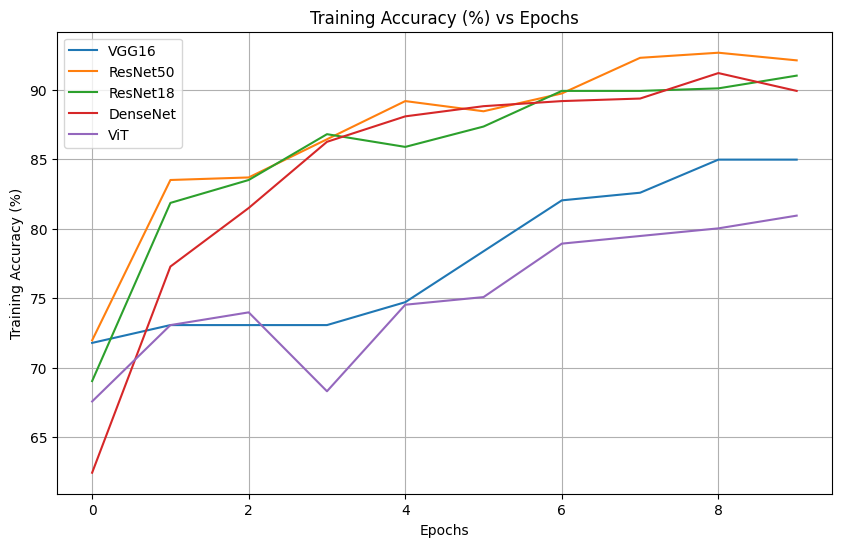

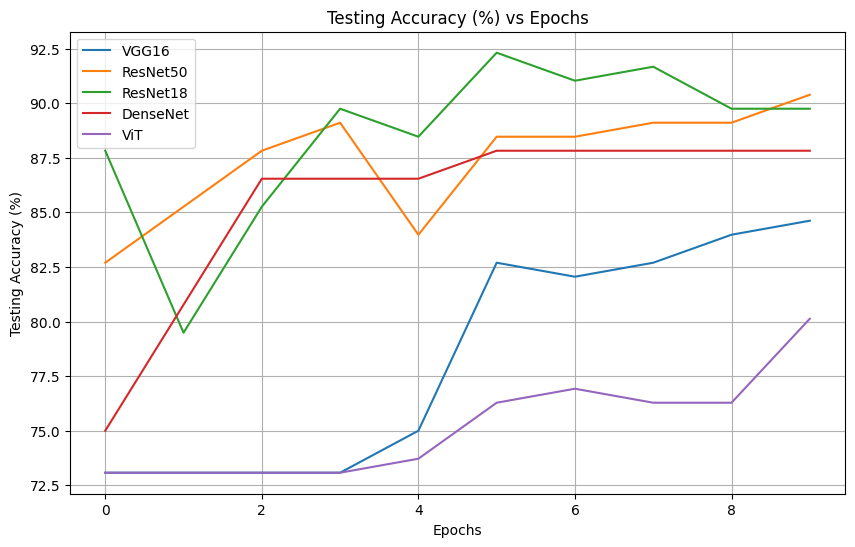

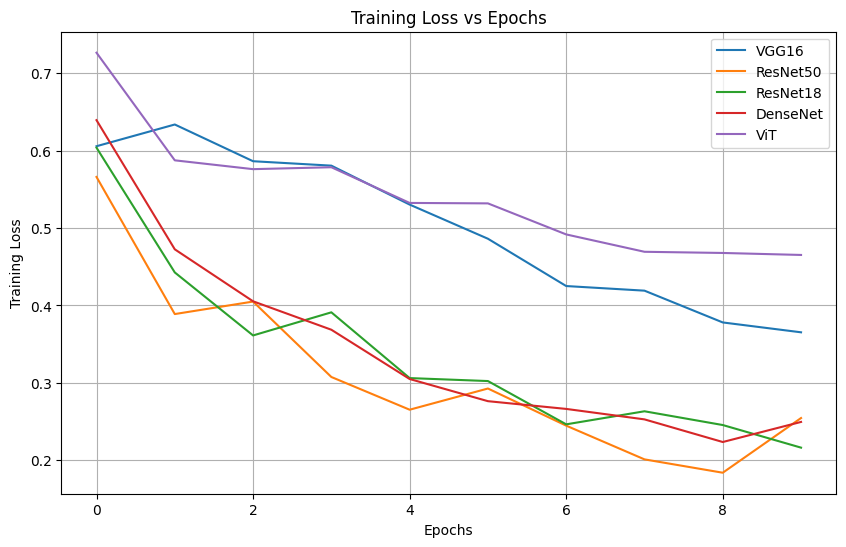

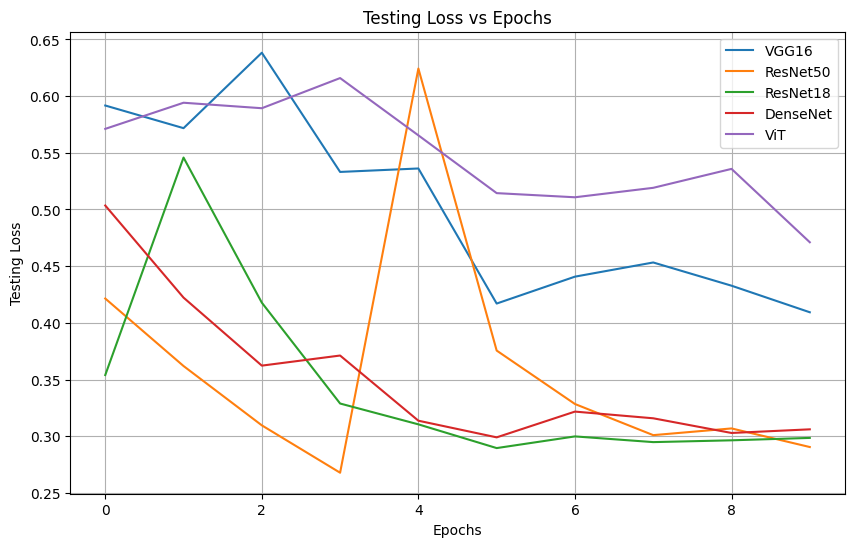

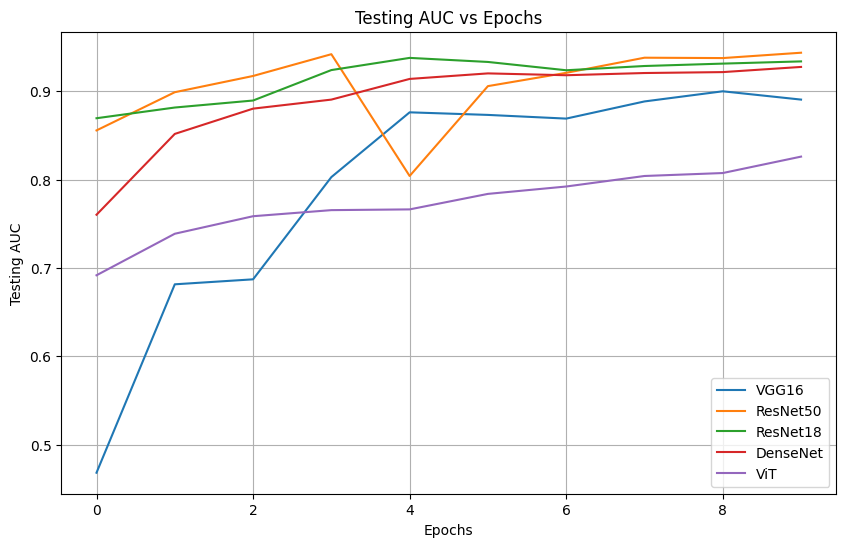

==> Training and visualization complete.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torchvision.models import resnet18, densenet121, vgg16, resnet50
from timm import create_model
from sklearn.metrics import roc_auc_score
import medmnist
from medmnist import INFO
import os
import matplotlib.pyplot as plt

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset handling
dataset_name = 'breastmnist'
info = INFO[dataset_name]
DataClass = getattr(medmnist, info['python_class'])
classes = info['label']

print(f'==> Preparing data for {dataset_name} with augmentations..')

# Data augmentation for training
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Normal transformations for testing
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Data loaders for training and testing
train_data = DataClass(split='train', transform=transform_train, download=True, size=224)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)

test_data = DataClass(split='test', transform=transform_test, download=True, size=224)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

# Ensure checkpoint directory exists
os.makedirs('./checkpoints', exist_ok=True)

# File to store checkpoint metadata
checkpoint_metadata_file = './checkpoints/checkpoints_metadata.txt'

# Utility to save checkpoint
def save_checkpoint(model, epoch, model_name, train_acc, test_acc, train_loss, test_loss, auc):
    checkpoint_path = f'./checkpoints/{model_name}_checkpoint_epoch{epoch + 1}.pth'
    torch.save(model.state_dict(), checkpoint_path)

    # Log metadata with the required details (without path)
    with open(checkpoint_metadata_file, 'a') as f:
        f.write(f'Model: {model_name}, Epoch: {epoch + 1}, '
                f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%, '
                f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, AUC: {auc:.4f}\n')

# Training and Testing Functions
def train_model(model, optimizer, criterion, scheduler, num_epochs=10, model_name='Model'):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []
    test_auc_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() > 1:  # Ensure targets are 1D
                targets = targets.squeeze(1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total
        train_loss /= len(trainloader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Testing
        model.eval()
        test_loss, correct, total = 0, 0, 0
        all_targets, all_preds = [], []

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                if targets.dim() > 1:
                    targets = targets.squeeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

        test_acc = 100. * correct / total
        test_loss /= len(testloader)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        try:
            auc = roc_auc_score(all_targets, all_preds)
        except ValueError:
            auc = 0
        test_auc_list.append(auc)

        scheduler.step()

        # Save checkpoint with relevant information
        save_checkpoint(model, epoch, model_name, train_acc, test_acc, train_loss, test_loss, auc)

        print(
            f"[{model_name}] Epoch {epoch + 1}/{num_epochs} | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Test Acc: {test_acc:.2f}% | AUC: {auc:.4f}"
        )

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list, test_auc_list

# Initialize Models
print('==> Initializing VGG16...')
vgg16_model = vgg16(pretrained=True)
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, len(classes))
vgg16_model = vgg16_model.to(device)

print('==> Initializing ResNet50...')
resnet50_model = resnet50(pretrained=True)
resnet50_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet50_model.fc.in_features, len(classes))
)
resnet50_model = resnet50_model.to(device)

print('==> Initializing ResNet18...')
resnet18_model = resnet18(pretrained=True)
resnet18_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18_model.fc.in_features, len(classes))
)
resnet18_model = resnet18_model.to(device)

print('==> Initializing DenseNet...')
densenet_model = densenet121(pretrained=True)
densenet_model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(densenet_model.classifier.in_features, len(classes))
)
densenet_model = densenet_model.to(device)

print('==> Initializing ViT...')
vit_model = create_model('vit_base_patch16_224', pretrained=True)
vit_model.head = nn.Linear(vit_model.head.in_features, len(classes))
vit_model = vit_model.to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()

optimizers = {
    "VGG16": optim.Adam(vgg16_model.parameters(), lr=1e-4),
    "ResNet50": optim.Adam(resnet50_model.parameters(), lr=1e-4),
    "ResNet18": optim.Adam(resnet18_model.parameters(), lr=1e-4),
    "DenseNet": optim.Adam(densenet_model.parameters(), lr=1e-4),
    "ViT": optim.Adam(vit_model.parameters(), lr=1e-4)
}

schedulers = {
    "VGG16": optim.lr_scheduler.StepLR(optimizers["VGG16"], step_size=5, gamma=0.1),
    "ResNet50": optim.lr_scheduler.StepLR(optimizers["ResNet50"], step_size=5, gamma=0.1),
    "ResNet18": optim.lr_scheduler.StepLR(optimizers["ResNet18"], step_size=5, gamma=0.1),
    "DenseNet": optim.lr_scheduler.StepLR(optimizers["DenseNet"], step_size=5, gamma=0.1),
    "ViT": optim.lr_scheduler.StepLR(optimizers["ViT"], step_size=5, gamma=0.1),
}

# Train and Test each model
results = {}
num_epochs = 10

for model_name, model in zip(
    ["VGG16", "ResNet50", "ResNet18", "DenseNet", "ViT"],
    [vgg16_model, resnet50_model, resnet18_model, densenet_model, vit_model]
):
    print(f'\nTraining {model_name}...')
    optimizer = optimizers[model_name]
    scheduler = schedulers[model_name]

    results[model_name] = train_model(
        model, optimizer, criterion, scheduler, num_epochs=num_epochs, model_name=model_name
    )

# Visualization
def plot_results(results, metric, ylabel):
    plt.figure(figsize=(10, 6))
    for model_name, result in results.items():
        plt.plot(result[metric], label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(results, metric=0, ylabel='Training Accuracy (%)')
plot_results(results, metric=1, ylabel='Testing Accuracy (%)')
plot_results(results, metric=2, ylabel='Training Loss')
plot_results(results, metric=3, ylabel='Testing Loss')
plot_results(results, metric=4, ylabel='Testing AUC')

print('==> Training and visualization complete.')


**This script is designed to predict a single sample using a pretrained model on the BreastMNIST dataset from the MedMNIST collection. Additionally, it visualizes the image alongside its true and predicted classes for interpretability**

True Class: 0 (Class 0)
Predicted Class: 1 (Class 1)


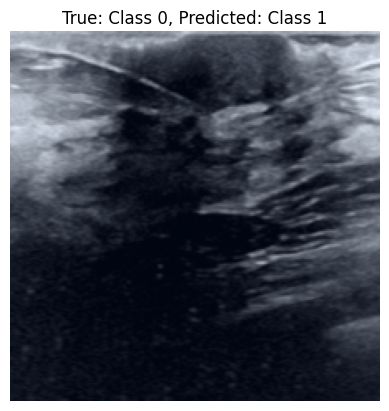

In [15]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision import transforms
from medmnist import INFO
import medmnist
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset details
dataset_name = 'breastmnist'
info = INFO[dataset_name]
DataClass = getattr(medmnist, info['python_class'])
label_mapping = info.get('label', {})
classes = {i: label_mapping[i] for i in range(len(label_mapping))} if isinstance(label_mapping, list) else {}

# Prediction function
def predict_sample(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # For single sample prediction, choose the first one from the batch
            predicted_label = predicted[0].item()  # Get the first prediction
            true_label = targets[0].item()  # Get the first target

            return inputs[0].cpu(), true_label, predicted_label

# Get a sample for prediction
sample_image, true_class, predicted_class = predict_sample(resnet50_model, testloader, device)

# Get class names
true_class_name = classes.get(true_class, f"Class {true_class}")
predicted_class_name = classes.get(predicted_class, f"Class {predicted_class}")
print(f"True Class: {true_class} ({true_class_name})")
print(f"Predicted Class: {predicted_class} ({predicted_class_name})")

# Visualize the sample
def visualize_sample(image, true_label, predicted_label):
    image = image.numpy().transpose(1, 2, 0)  # Convert to HWC format
    image = (image - image.min()) / (image.max() - image.min())  # Normalize for visualization
    plt.imshow(image)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
  # Visualizing the sample
visualize_sample(sample_image, true_class_name, predicted_class_name)




**The script extends the single-sample prediction approach to handle batch predictions and displays the results for a specified number of samples**

Sample 1: True Class: Class 0, Predicted Class: Class 1


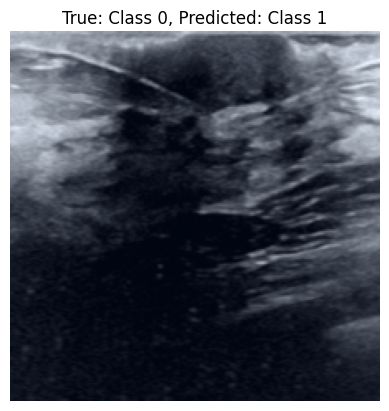

Sample 2: True Class: Class 1, Predicted Class: Class 1


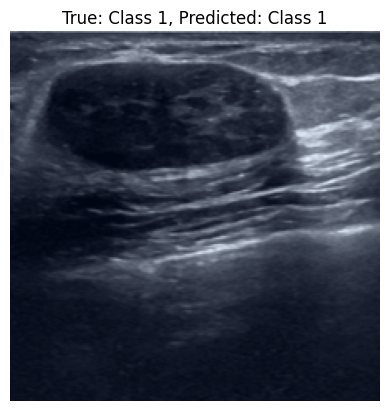

Sample 3: True Class: Class 1, Predicted Class: Class 1


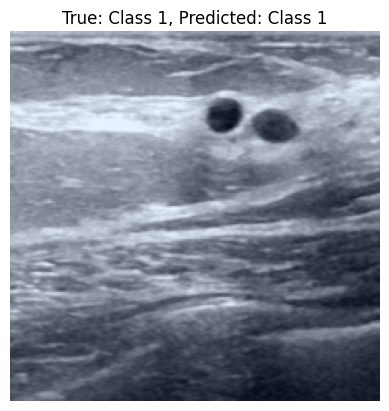

Sample 4: True Class: Class 1, Predicted Class: Class 1


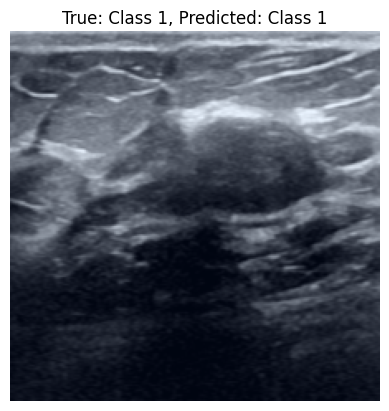

Sample 5: True Class: Class 1, Predicted Class: Class 1


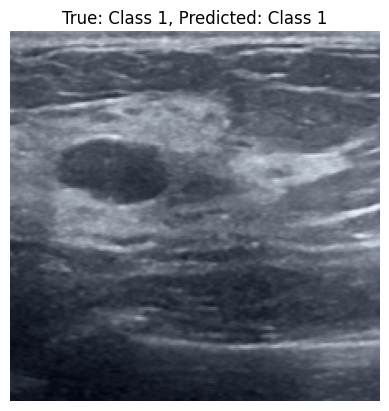

Sample 6: True Class: Class 1, Predicted Class: Class 1


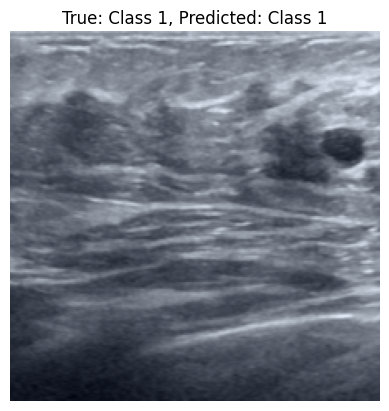

Sample 7: True Class: Class 0, Predicted Class: Class 0


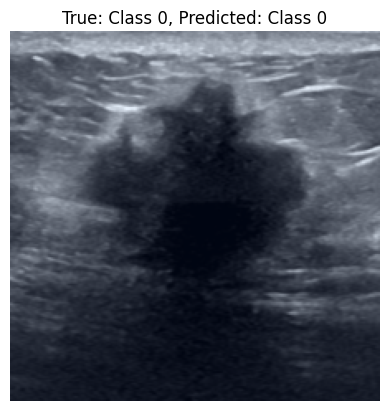

Sample 8: True Class: Class 0, Predicted Class: Class 1


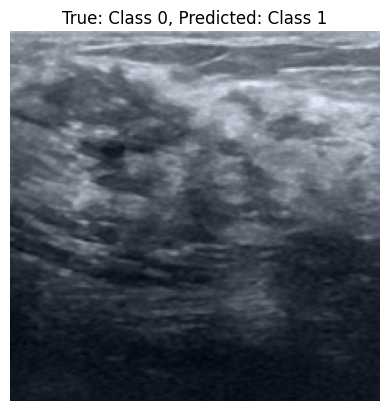

Sample 9: True Class: Class 1, Predicted Class: Class 1


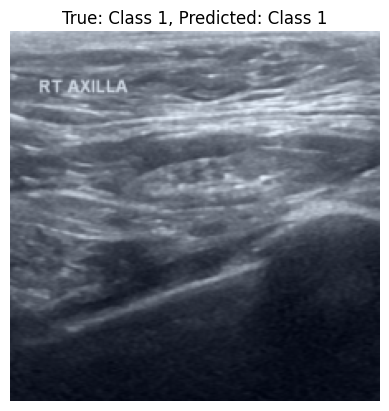

Sample 10: True Class: Class 1, Predicted Class: Class 1


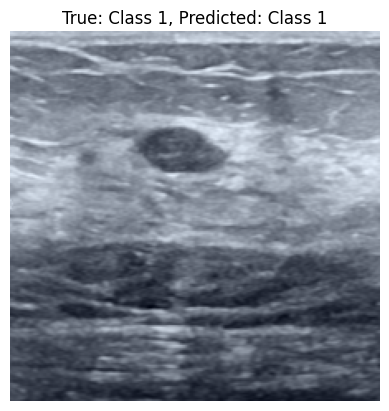

In [16]:
def predict_batch(model, dataloader, device, num_samples=5):
    model.eval()
    predictions = []
    count = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        for i in range(inputs.size(0)):
            if count >= num_samples:
                break
            predictions.append((inputs[i].cpu(), targets[i].item(), predicted[i].item()))
            count += 1
        if count >= num_samples:
            break
    return predictions

# Predict and display results
num_samples = 10
results = predict_batch(resnet50_model, testloader, device, num_samples=num_samples)

for idx, (image, true_class, predicted_class) in enumerate(results):
    true_class_name = classes.get(true_class, f"Class {true_class}")
    predicted_class_name = classes.get(predicted_class, f"Class {predicted_class}")
    print(f"Sample {idx + 1}: True Class: {true_class_name}, Predicted Class: {predicted_class_name}")
    visualize_sample(image, true_class_name, predicted_class_name)
